In [391]:
# Doesn't seem to work very well

In [281]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import os
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import time
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, cohen_kappa_score, confusion_matrix

from sklearn.linear_model import LinearRegression, ElasticNet 

import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter
import datetime
from sklearn.pipeline import Pipeline    # helps with multiple estimators

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import make_scorer, f1_score

from xgboost import XGBClassifier


In [46]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [6]:
train = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv')
test = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv')
merchants = pd.read_csv('/Users/jincui/Downloads/ELO/merchants.csv')
ht = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv')

In [327]:
for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['start_year'] = df['first_active_month'].dt.year
    df['start_month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

ytrain = train['target']
del train['target']

In [328]:
ht['authorized_flag'] = ht['authorized_flag'].map({'Y':1, 'N':0})
ht['category_1'] = ht['category_1'].map({'Y':1, 'N':0})

In [329]:
ht['category_2x1'] = (ht['category_2'] == 1) + 0
ht['category_2x2'] = (ht['category_2'] == 2) + 0
ht['category_2x3'] = (ht['category_2'] == 3) + 0
ht['category_2x4'] = (ht['category_2'] == 4) + 0
ht['category_2x5'] = (ht['category_2'] == 5) + 0
ht['category_3A'] = (ht['category_3'].astype(str) == 'A') + 0
ht['category_3B'] = (ht['category_3'].astype(str) == 'B') + 0
ht['category_3C'] = (ht['category_3'].astype(str) == 'C') + 0

In [330]:
def aggregate_historical_transactions(history):
    # np.ptp is max - min
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2': ['nunique'],
        'category_3A': ['sum'],
        'category_3B': ['sum'],
        'category_3C': ['sum'],
        'category_2x1': ['sum','mean'],
        'category_2x2': ['sum','mean'],
        'category_2x3': ['sum','mean'],
        'category_2x4': ['sum','mean'],
        'category_2x5': ['sum','mean'],        
        'city_id': ['nunique'],
        'installments': ['sum', 'mean', 'median', 'max', 'min', 'std'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['min', 'max', 'mean'],
        'purchase_amount': [np.ptp, 'sum', 'mean', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'mean','min', 'std'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],

        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_historical_transactions(ht)

#del ht
#gc.collect()

In [402]:
ht[['card_id', 'purchase_date']]

,card_id,purchase_date
0,C_ID_4e6213e9bc,1.498405e+09
1,C_ID_4e6213e9bc,1.500121e+09
2,C_ID_4e6213e9bc,1.502316e+09
3,C_ID_4e6213e9bc,1.504347e+09
4,C_ID_4e6213e9bc,1.489108e+09
5,C_ID_4e6213e9bc,1.519462e+09
6,C_ID_4e6213e9bc,1.490055e+09
7,C_ID_4e6213e9bc,1.511036e+09
8,C_ID_4e6213e9bc,1.496355e+09
9,C_ID_4e6213e9bc,1.489679e+09


In [403]:
a = np.arange(9)
np.ptp(a)

8

In [331]:
new_merchant = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv')


In [332]:
new_merchant['authorized_flag'] = new_merchant['authorized_flag'].map({'Y':1, 'N':0})

new_merchant['category_1'] = new_merchant['category_1'].map({'Y':1, 'N':0})
new_merchant['category_3A'] = (new_merchant['category_3'].astype(str) == 'A') + 0
new_merchant['category_3B'] = (new_merchant['category_3'].astype(str) == 'B') + 0
new_merchant['category_3C'] = (new_merchant['category_3'].astype(str) == 'C') + 0

new_merchant['category_2x1'] = (new_merchant['category_2'] == 1) + 0
new_merchant['category_2x2'] = (new_merchant['category_2'] == 2) + 0
new_merchant['category_2x3'] = (new_merchant['category_2'] == 3) + 0
new_merchant['category_2x4'] = (new_merchant['category_2'] == 4) + 0
new_merchant['category_2x5'] = (new_merchant['category_2'] == 5) + 0

In [333]:
new_merchant['purchase_date'] = pd.DatetimeIndex(new_merchant['purchase_date']).\
                                      astype(np.int64) * 1e-9

In [334]:
def aggregate_new_transactions(new_trans):    
    
    
    agg_func = {
        'authorized_flag': ['sum'],
        'category_1': ['sum', 'mean'],
        'category_2': ['nunique'],
        'category_3A': ['sum'],
        'category_3B': ['sum'],
        'category_3C': ['sum'],     
        'category_2x1': ['sum','mean'],
        'category_2x2': ['sum','mean'],
        'category_2x3': ['sum','mean'],
        'category_2x4': ['sum','mean'],
        'category_2x5': ['sum','mean'],        

        'city_id': ['nunique'],
        'installments': ['sum', 'mean', 'median', 'max', 'min', 'std'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['min', 'max'],
        'purchase_amount': ['sum', 'mean', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique']        
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_trans = aggregate_new_transactions(new_merchant)

#del new_merchant

In [335]:
print(train.shape)
print(test.shape)

xtrain = pd.merge(train, new_trans, on='card_id', how='left')
xtest = pd.merge(test, new_trans, on='card_id', how='left')

del new_trans

print(xtrain.shape)
print(xtest.shape)

xtrain = pd.merge(xtrain, history, on='card_id', how='left')
xtest = pd.merge(xtest, history, on='card_id', how='left')

del history

print(xtrain.shape)
print(xtest.shape)

(201917, 8)
(123623, 8)
(201917, 48)
(123623, 48)
(201917, 90)
(123623, 90)


In [336]:
categorical_feats = ['feature_1', 'feature_2', 'feature_3']

for col in categorical_feats:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(xtrain[col].values.astype('str')) + list(xtest[col].values.astype('str')))
    xtrain[col] = lbl.transform(list(xtrain[col].values.astype('str')))
    xtest[col] = lbl.transform(list(xtest[col].values.astype('str')))

feature_1
feature_2
feature_3


In [337]:
df_all = pd.concat([xtrain, xtest])
df_all = pd.get_dummies(df_all, columns=categorical_feats)

len_train = xtrain.shape[0]

xtrain = df_all[:len_train]
xtest = df_all[len_train:]

In [338]:
xtrain.drop('first_active_month', axis=1, inplace=True)
xtest.drop('first_active_month', axis=1, inplace=True)

/Users/jincui/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [339]:
# prepare for modeling
id_train = xtrain['card_id'].copy(); xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); xtest.drop('card_id', axis = 1, inplace = True)


nfolds = 10
folds = KFold(n_splits= nfolds, shuffle=True, random_state=15)

In [340]:
#sc = StandardScaler()
sc = RobustScaler()
sc.fit(pd.concat([xtrain,xtest],axis=0))

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [341]:
xtrain_sc = pd.DataFrame(sc.transform(xtrain), columns=xtrain.columns)
xtest_sc = pd.DataFrame(sc.transform(xtest), columns=xtest.columns)

In [342]:
xtrain_sc = xtrain_sc.fillna(0)
#xtrain_sc = xtrain_sc.fillna(xtrain_sc.mean())

In [343]:
binary_ytrain = ytrain.copy()
binary_ytrain[ytrain == -33.21928095] = 1
binary_ytrain[ytrain != -33.21928095] = 0

In [344]:
models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}
    #'SVC': SVC(),


params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32], 'class_weight': ['balanced', None]},
    'DecisionTreeClassifier': { 'max_features': ['auto', 'sqrt','log2', None], 'class_weight': ['balanced', None] },
    'RandomForestClassifier': { 'n_estimators': [16, 32], 'class_weight': ['balanced', None] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
}

'''
 'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
'''
   


kappa_scorer = make_scorer(cohen_kappa_score)


# cv=StratifiedKFold(n_splits=2, random_state=42), n_jobs=1
# socring=cohen_kappa_score



In [345]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_sc, binary_ytrain, scoring=kappa_scorer, n_jobs=8, cv=10)


Running GridSearchCV for ExtraTreesClassifier.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


KeyboardInterrupt: 

In [78]:
helper1.score_summary(sort_by='max_score')


ExtraTreesClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,class_weight,learning_rate,max_features,n_estimators
18,GradientBoostingClassifier,-0.00995088,0.0593298,0.15846,0.0691084,NaN,0.8,NaN,16
19,GradientBoostingClassifier,-0.00863193,0.0628802,0.157311,0.0640838,NaN,0.8,NaN,32
11,DecisionTreeClassifier,0.0605828,0.0836431,0.104566,0.0123201,None,NaN,None,NaN
9,DecisionTreeClassifier,0.0404592,0.070393,0.100533,0.0189792,None,NaN,sqrt,NaN
4,DecisionTreeClassifier,0.0310652,0.0662377,0.0968228,0.0187699,balanced,NaN,auto,NaN
8,DecisionTreeClassifier,0.0344293,0.0711699,0.0953492,0.0172202,None,NaN,auto,NaN
5,DecisionTreeClassifier,0.0340205,0.0613608,0.0921455,0.0195537,balanced,NaN,sqrt,NaN
7,DecisionTreeClassifier,0.0375164,0.0719956,0.091105,0.0144538,balanced,NaN,None,NaN
6,DecisionTreeClassifier,0.040602,0.0634364,0.0895103,0.0126459,balanced,NaN,log2,NaN
10,DecisionTreeClassifier,0.0407272,0.056975,0.0759437,0.0119427,None,NaN,log2,NaN


In [82]:

x0, x1, y0, y1 = train_test_split(xtrain_sc, binary_ytrain, test_size=0.33, random_state=42)


## Seems like DecisionTreeclassifier works better:
    class_weight=None
    max_feature=None
    criterion='entropy

In [95]:
model = DecisionTreeClassifier(max_features='auto', class_weight='balanced')
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[65284,   611],
       [  672,    66]])

In [102]:
model = DecisionTreeClassifier(max_features='sqrt', class_weight='balanced')
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[65245,   650],
       [  682,    56]])

In [127]:
model = DecisionTreeClassifier(max_features=None, class_weight=None, criterion='entropy')
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[65099,   796],
       [  658,    80]])

## Undersampling

In [141]:
binary_ytrain[binary_ytrain==0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914,
            201915, 201916],
           dtype='int64', length=199710)

In [346]:
np.random.seed(0) 
random_indices = np.random.choice(binary_ytrain[binary_ytrain==0].index, len(binary_ytrain[binary_ytrain==1]),
                                  replace=False,
                                  )
random_indices
balanced_indices = np.concatenate([random_indices, binary_ytrain[binary_ytrain==1].index])
balanced_indices

array([ 43921, 100451, 197579, ..., 201368, 201519, 201521])

In [347]:
## balanced data


xtrain_bl = xtrain_sc.iloc[balanced_indices,:]

##xtrain_bl = xtrain.iloc[balanced_indices,:]

ytrain_bl = binary_ytrain[balanced_indices]

In [348]:
Counter(ytrain_bl)

Counter({0.0: 2207, 1.0: 2207})

In [349]:
models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32], 'class_weight': ['balanced', None]},
    'DecisionTreeClassifier': { 'max_features': ['auto', 'sqrt','log2', None], 'class_weight': ['balanced', None] },
    'RandomForestClassifier': { 'n_estimators': [16, 32], 'class_weight': ['balanced', None] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
}

In [350]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=8, cv=10)


Running GridSearchCV for ExtraTreesClassifier.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    3.1s finished


In [351]:
helper1.score_summary(sort_by='max_score')

ExtraTreesClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,class_weight,learning_rate,max_features,n_estimators
12,RandomForestClassifier,0.748235,0.797364,0.839729,0.0296623,balanced,NaN,NaN,16
14,RandomForestClassifier,0.751174,0.790943,0.836689,0.0252516,None,NaN,NaN,16
1,ExtraTreesClassifier,0.753488,0.794673,0.835886,0.0229085,balanced,NaN,NaN,32
15,RandomForestClassifier,0.748268,0.806283,0.834437,0.0232028,None,NaN,NaN,32
17,AdaBoostClassifier,0.776786,0.800843,0.829694,0.020368,NaN,NaN,NaN,32
18,GradientBoostingClassifier,0.764045,0.792882,0.824053,0.0233094,NaN,0.8,NaN,16
13,RandomForestClassifier,0.781609,0.805421,0.823009,0.0139736,balanced,NaN,NaN,32
16,AdaBoostClassifier,0.767123,0.799144,0.821978,0.018286,NaN,NaN,NaN,16
3,ExtraTreesClassifier,0.761682,0.793689,0.821505,0.01676,None,NaN,NaN,32
20,GradientBoostingClassifier,0.750572,0.791155,0.820046,0.0248746,NaN,1,NaN,16


In [352]:
models1 = {

    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
}

params1 = {
    'RandomForestClassifier': { 'n_estimators': [32, 64, 128],
                               'class_weight': [ None],
                               'criterion' : ['gini', 'entropy'],
                               'max_features': ['auto', None, 'sqrt', 'log2']},
    
    'AdaBoostClassifier':  { 'n_estimators': [16, 8, 4],
                            'learning_rate': [0.6, 0.8, 1]},
}

In [353]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=10, cv=10)
helper1.score_summary(sort_by='mean_score')

Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:  1.6min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s


RandomForestClassifier
AdaBoostClassifier


[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:    2.3s finished
/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,class_weight,criterion,learning_rate,max_features,n_estimators
20,RandomForestClassifier,0.768182,0.816394,0.857768,0.024141,None,entropy,NaN,sqrt,128
15,RandomForestClassifier,0.775229,0.814437,0.848889,0.0216835,None,entropy,NaN,None,32
17,RandomForestClassifier,0.769585,0.814363,0.846491,0.0230759,None,entropy,NaN,None,128
13,RandomForestClassifier,0.748837,0.814147,0.852747,0.0267024,None,entropy,NaN,auto,64
14,RandomForestClassifier,0.789116,0.81268,0.844639,0.0189897,None,entropy,NaN,auto,128
22,RandomForestClassifier,0.764977,0.812587,0.849673,0.0226056,None,entropy,NaN,log2,64
19,RandomForestClassifier,0.775229,0.81258,0.84141,0.0199753,None,entropy,NaN,sqrt,64
16,RandomForestClassifier,0.773756,0.811951,0.840708,0.0193522,None,entropy,NaN,None,64
23,RandomForestClassifier,0.781609,0.811292,0.845316,0.0210927,None,entropy,NaN,log2,128
11,RandomForestClassifier,0.781818,0.811181,0.847162,0.0211865,None,gini,NaN,log2,128


In [193]:
x0, x1, y0, y1 = train_test_split(xtrain_bl, ytrain_bl, test_size=0.33, random_state=42)
model = RandomForestClassifier(max_features=None, n_estimators=128,
                               criterion='entropy', class_weight=None,
                              min_samples_leaf=25)
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[624, 122],
       [148, 563]])

In [247]:
models1 = {

    'RandomForestClassifier': RandomForestClassifier(),
}

params1 = {
    'RandomForestClassifier': { 'n_estimators': [128],
                               'class_weight': [ None],
                               'criterion' : ['entropy'],
                               'max_features': [None],
                                'min_samples_leaf': [2,5,10,25,50],
                              'oob_score': [True, False]},
    
}


In [248]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=8, cv=10)
helper1.score_summary(sort_by='max_score')

Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
x0, x1, y0, y1 = train_test_split(xtrain_bl, ytrain_bl, test_size=0.33, random_state=42)
model = RandomForestClassifier(max_features=None, n_estimators=128,
                               criterion='entropy', class_weight=None,
                              min_samples_leaf=5,
                              oob_score=True)
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

In [ ]:
# this is the best I can get out of RandomForestClassifier

In [197]:
model = SVC(gamma='auto')
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[587, 159],
       [163, 548]])

In [199]:
## NOT GOOD!

models1 = {

    'SVC': SVC(),
}

params1 = {
    'SVC': { 'gamma': [ 'auto', 0.1, 0.5],
               'kernel' : ['sigmoid', 'rbf', 'poly'],
               'C': [1, 10]
           }, 
}
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=8, cv=10)
helper1.score_summary(sort_by='max_score')

Running GridSearchCV for SVC.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.4s


SVC


[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:  2.1min finished


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel
1,SVC,0.755656,0.788819,0.828947,0.0218017,1,auto,rbf
10,SVC,0.756264,0.776615,0.790068,0.0118391,10,auto,rbf
2,SVC,0.684597,0.740415,0.783599,0.0291647,1,auto,poly
11,SVC,0.710407,0.751491,0.780269,0.0195989,10,auto,poly
4,SVC,0.66005,0.702263,0.732892,0.0209753,1,0.1,rbf
5,SVC,0.665072,0.699133,0.731377,0.019466,1,0.1,poly
0,SVC,0.626168,0.678863,0.724444,0.031616,1,auto,sigmoid
14,SVC,0.665208,0.692441,0.721088,0.0206763,10,0.1,poly
17,SVC,0.666667,0.692717,0.721088,0.0206022,10,0.5,poly
8,SVC,0.666667,0.692717,0.721088,0.0206022,1,0.5,poly


In [209]:
# NO GOOD!
models1 = {
    'LinearSVC': LinearSVC(),
}
params1 = {
    'LinearSVC': {
        'penalty': ['l1', 'l2'],
        'C': [1.0, 5.0, 10],
        'tol': [1e-4, 1e-3, 1e-2],
        'dual': [False]
        
    }
}
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=8, cv=10)
helper1.score_summary(sort_by='max_score')

Running GridSearchCV for LinearSVC.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.2s


LinearSVC


[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:   30.9s finished


,estimator,min_score,mean_score,max_score,std_score,C,dual,penalty,tol
15,LinearSVC,0.724138,0.743164,0.780269,0.0150358,10,False,l2,0.0001
17,LinearSVC,0.719626,0.741466,0.779279,0.0158442,10,False,l2,0.01
11,LinearSVC,0.719626,0.740758,0.779279,0.0164293,5,False,l2,0.01
8,LinearSVC,0.721698,0.741629,0.779279,0.0169183,5,False,l1,0.01
1,LinearSVC,0.724299,0.743632,0.776786,0.0144994,1,False,l1,0.001
16,LinearSVC,0.724138,0.743909,0.776786,0.0140251,10,False,l2,0.001
13,LinearSVC,0.728972,0.744306,0.776786,0.0127853,10,False,l1,0.001
12,LinearSVC,0.728448,0.74388,0.776786,0.0131538,10,False,l1,0.0001
10,LinearSVC,0.724138,0.744238,0.776786,0.0138832,5,False,l2,0.001
0,LinearSVC,0.719626,0.743956,0.776786,0.0148096,1,False,l1,0.0001


In [354]:
models1 = {
    'XGBoostClassifier': XGBClassifier(),
}
params1 = {
    'XGBoostClassifier': {
            'learning_rate': [0.025, 0.05],
            'seed': [1],
            'gamma': [0.6, 0.8],
            'subsample': [0.5, 0.8],
            'booster': ['gbtree'],
            'lambda': [1, 10],
            'alpha': [0, 2],
            'max_depth': [6],
            'objective': ['binary:hinge']
    }
}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(xtrain_bl, ytrain_bl, scoring='f1', n_jobs=-1, cv=10)


Running GridSearchCV for XGBoostClassifier.
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.9min finished


In [355]:
helper1.score_summary(sort_by='mean_score')

XGBoostClassifier


,estimator,min_score,mean_score,max_score,std_score,alpha,booster,gamma,lambda,learning_rate,max_depth,objective,seed,subsample
31,XGBoostClassifier,0.787879,0.820386,0.84696,0.0190135,2,gbtree,0.8,10,0.05,6,binary:hinge,1,0.8
15,XGBoostClassifier,0.787879,0.820386,0.84696,0.0190135,0,gbtree,0.8,10,0.05,6,binary:hinge,1,0.8
27,XGBoostClassifier,0.787879,0.820386,0.84696,0.0190135,2,gbtree,0.8,1,0.05,6,binary:hinge,1,0.8
11,XGBoostClassifier,0.787879,0.820386,0.84696,0.0190135,0,gbtree,0.8,1,0.05,6,binary:hinge,1,0.8
10,XGBoostClassifier,0.781659,0.820357,0.853503,0.0241218,0,gbtree,0.8,1,0.05,6,binary:hinge,1,0.5
30,XGBoostClassifier,0.781659,0.820357,0.853503,0.0241218,2,gbtree,0.8,10,0.05,6,binary:hinge,1,0.5
14,XGBoostClassifier,0.781659,0.820357,0.853503,0.0241218,0,gbtree,0.8,10,0.05,6,binary:hinge,1,0.5
26,XGBoostClassifier,0.781659,0.820357,0.853503,0.0241218,2,gbtree,0.8,1,0.05,6,binary:hinge,1,0.5
21,XGBoostClassifier,0.783898,0.819958,0.854167,0.0235932,2,gbtree,0.6,10,0.025,6,binary:hinge,1,0.8
17,XGBoostClassifier,0.783898,0.819958,0.854167,0.0235932,2,gbtree,0.6,1,0.025,6,binary:hinge,1,0.8


In [356]:
x0, x1, y0, y1 = train_test_split(xtrain_bl, ytrain_bl, test_size=0.33, random_state=42)
model = XGBClassifier(learning_rate=0.05, gamma=0.8,
                      max_depth=6, alpha=6, reg_lambda=10,
                      objective='binary:hinge',
                      booster='gbtree',
                      subsample=0.6,
                      seed=1
                     )
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[591, 155],
       [111, 600]])

In [237]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [357]:
rmse(ypred, y1)

0.42727850206314616

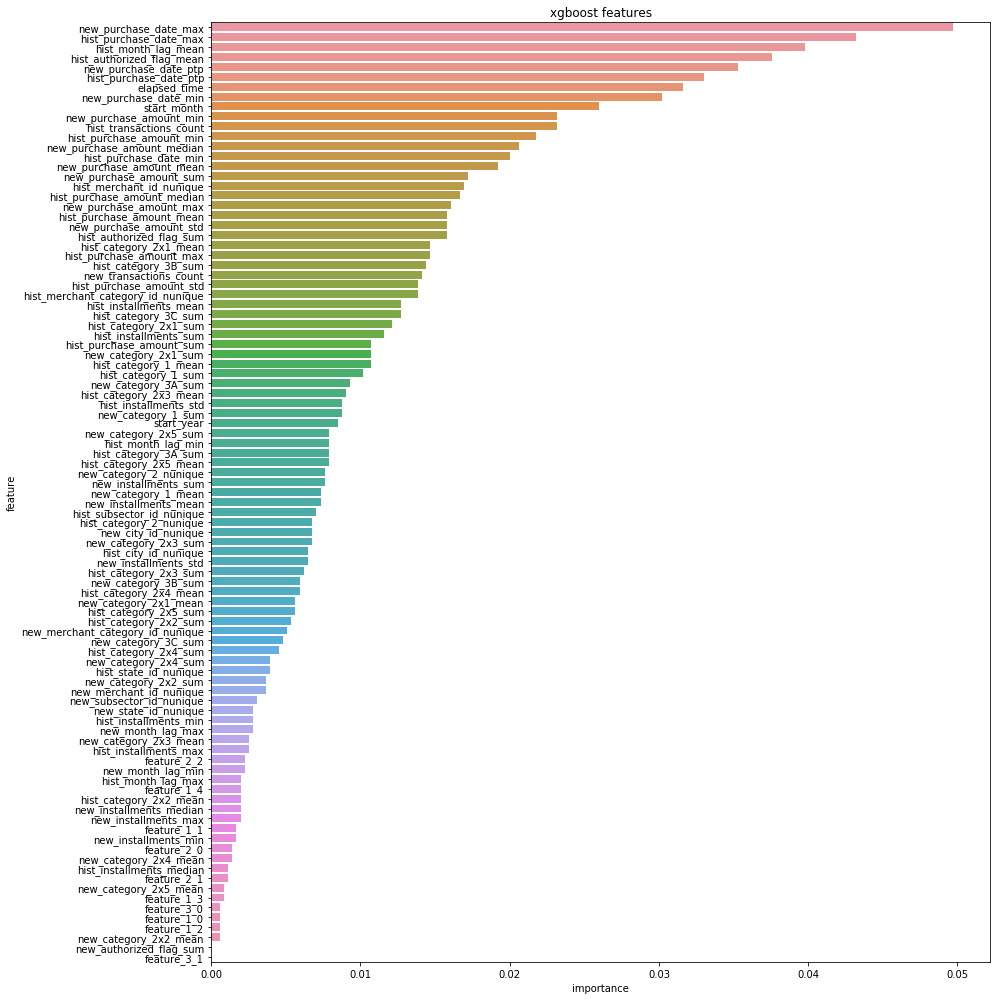

In [358]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain_bl.columns
ximp['importance'] = model.feature_importances_

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                           ascending=False))
plt.title('xgboost features')
plt.tight_layout()

In [362]:
xtrain_bl_sub = xtrain_bl.drop(['feature_3_1', 'new_authorized_flag_sum', 'feature_1_0'                               
                               ], axis=1)
xtrain_bl_sub.shape
#'feature_1_3', 'feature_2_0',
# 'feature_3_0', 'hist_installments_min', 'feature_2_2',
#'new_category_2x2_mean', 'hist_installments_max',

(4414, 92)

In [363]:
x0, x1, y0, y1 = train_test_split(xtrain_bl_sub, ytrain_bl, test_size=0.33, random_state=42)
model = XGBClassifier(learning_rate=0.05, gamma=1,
                      max_depth=6, alpha=6, reg_lambda=20,
                      objective='binary:hinge',
                      booster='gbtree',
                      subsample=0.6,
                      seed=1,
                      eval_metric='error'
                     )
model.fit(x0, y0)
ypred = model.predict(x1)
confusion_matrix(y1, ypred)

array([[584, 162],
       [110, 601]])

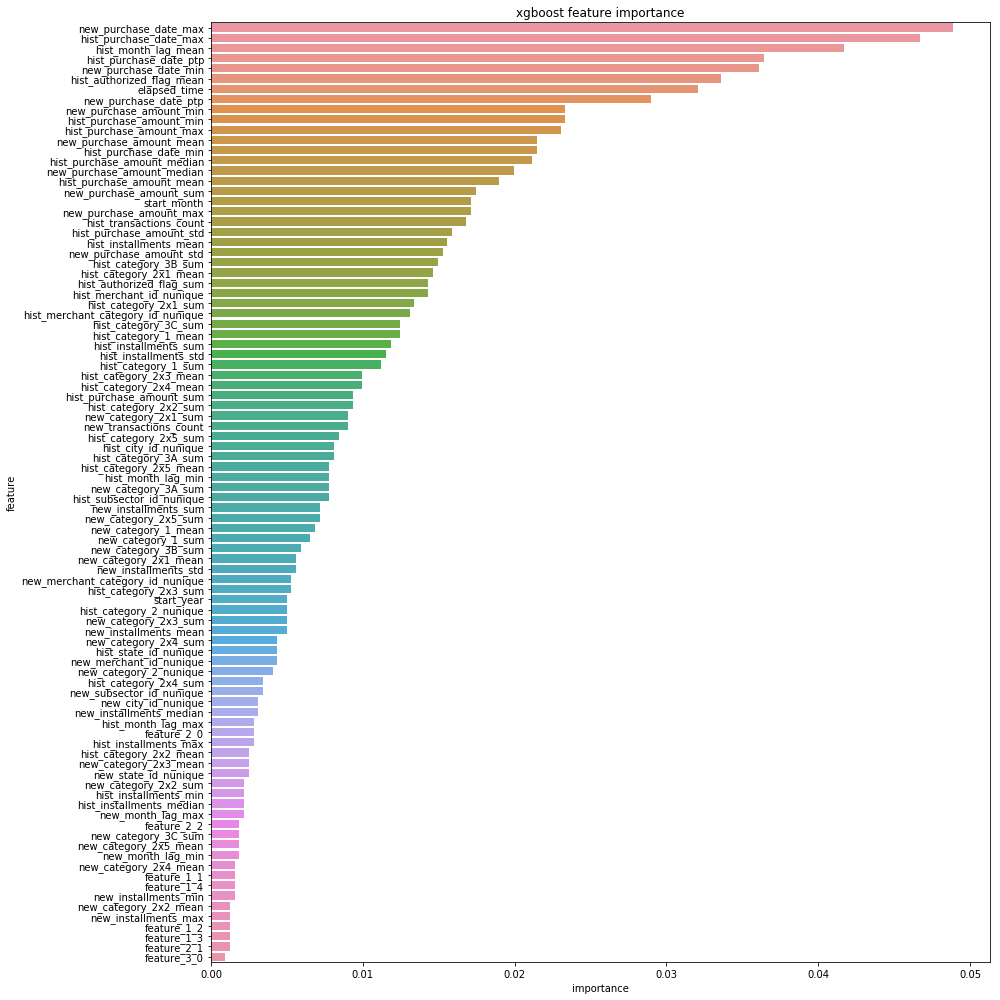

In [364]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain_bl_sub.columns
ximp['importance'] = model.feature_importances_

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                           ascending=False))
plt.title('xgboost feature importance')
plt.tight_layout()

In [388]:
value = Counter(ytrain).keys()
count = Counter(ytrain).values()

In [405]:
c = pd.DataFrame()
c['value'] = value
c['count'] = count
c.sort_values(by='count', ascending=False)

,value,count
64,-33.219281,2207
74,0.000000,1630
289,1.000000,117
1011,-1.000000,81
1400,-0.584963,35
4789,0.584963,28
8580,-1.321928,19
6064,0.284918,17
6590,1.584963,14
1840,0.342052,13


In [404]:
c.sort_values(by='value')

,value,count
64,-33.219281,2207
45677,-17.608147,1
5777,-17.492640,1
157328,-17.441923,1
8232,-17.189636,1
165487,-15.835656,1
136936,-15.553269,1
176449,-15.400146,1
124284,-15.291387,1
127301,-15.103165,1


(array([2.207e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

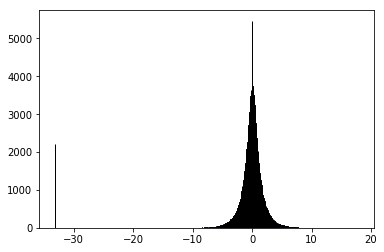

In [382]:
plt.hist(ytrain, bins=1000,
             color = 'blue', edgecolor = 'black')


In [406]:
xtrain.head()

,start_year,start_month,elapsed_time,new_transactions_count,new_authorized_flag_sum,new_category_1_sum,new_category_1_mean,new_category_2_nunique,new_category_3A_sum,new_category_3B_sum,new_category_3C_sum,new_category_2x1_sum,new_category_2x1_mean,new_category_2x2_sum,new_category_2x2_mean,new_category_2x3_sum,new_category_2x3_mean,new_category_2x4_sum,new_category_2x4_mean,new_category_2x5_sum,new_category_2x5_mean,new_city_id_nunique,new_installments_sum,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_merchant_category_id_nunique,new_merchant_id_nunique,new_month_lag_min,new_month_lag_max,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_date_ptp,new_purchase_date_max,new_purchase_date_min,new_state_id_nunique,new_subsector_id_nunique,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_nunique,hist_category_3A_sum,hist_category_3B_sum,hist_category_3C_sum,hist_category_2x1_sum,hist_category_2x1_mean,hist_category_2x2_sum,hist_category_2x2_mean,hist_category_2x3_sum,hist_category_2x3_mean,hist_category_2x4_sum,hist_category_2x4_mean,hist_category_2x5_sum,hist_category_2x5_mean,hist_city_id_nunique,hist_installments_sum,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_state_id_nunique,hist_subsector_id_nunique,feature_1_0,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_2_0,feature_2_1,feature_2_2,feature_3_0,feature_3_1
0,2017.0,6.0,245.0,23.0,23.0,0.0,0.000000,1.0,23.0,0.0,0.0,23.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,0.0,0.000000,14.0,23.0,1.0,2.0,-13.244202,-0.575835,-0.581180,-0.296112,-0.724368,0.135812,4742309.0,1.525001e+09,1.520259e+09,1.0,10.0,260,247,0.950000,0,0.000000,2,256,4,0,257,0.988462,0,0.0,0,0.0,0,0.000000,3,0.011538,7,4,0.015385,0.0,1,0,0.123314,41,94,-8,0,-3.911538,-165.968739,-0.638341,-0.698042,2.258395,-0.739395,0.212139,20977987.0,1.519551e+09,1.498573e+09,3,21,0,0,0,0,1,0,1,0,0,1
1,2017.0,1.0,396.0,6.0,6.0,0.0,0.000000,1.0,0.0,6.0,0.0,6.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,6.0,1.000000,1.0,1.0,1.0,0.000000,5.0,6.0,1.0,2.0,-4.355735,-0.725956,-0.732633,-0.701858,-0.739410,0.014326,4887632.0,1.522393e+09,1.517505e+09,1.0,4.0,350,339,0.968571,31,0.088571,1,0,276,72,319,0.911429,0,0.0,0,0.0,0,0.000000,0,0.000000,9,543,1.551429,1.0,10,-1,1.510777,57,142,-12,0,-5.031429,-210.006336,-0.600018,-0.708590,4.630299,-0.742400,0.384967,33717687.0,1.517438e+09,1.483720e+09,3,24,0,0,0,1,0,1,0,0,1,0
2,2016.0,8.0,549.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,NaN,1.0,1.0,2.0,2.0,-0.700326,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,1.524937e+09,1.524937e+09,1.0,1.0,43,41,0.953488,0,0.000000,2,43,0,0,4,0.093023,0,0.0,0,0.0,0,0.000000,39,0.906977,5,0,0.000000,0.0,0,0,0.000000,8,13,-13,0,-8.604651,-29.167391,-0.678311,-0.698868,-0.145847,-0.730138,0.087380,35635623.0,1.519759e+09,1.484123e+09,2,7,0,1,0,0,0,0,1,0,1,0
3,2017.0,9.0,153.0,7.0,7.0,1.0,0.142857,1.0,0.0,6.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,6.0,0.857143,0.0,0.0,2.0,5.0,0.714286,1.0,1.0,-1.0,0.755929,6.0,7.0,1.0,2.0,-4.654372,-0.664910,-0.691610,-0.566740,-0.734135,0.065882,3625505.0,1.524049e+09,1.520424e+09,2.0,5.0,77,77,1.000000,12,0.155844,2,0,68,7,12,0.155844,0,0.0,0,0.0,53,0.688312,0,0.000000,7,84,1.090909,1.0,3,-1,0.588974,25,50,-5,0,-2.831169,-49.4

In [409]:
train = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv')
a = train['target'][train['target']!=-33.21928095]

In [431]:
(len(train)-len(a))/len(train)*123623

1351.2282819178176

In [412]:
a.mean()

-0.03087931272485137

In [413]:
a.std()

1.7177929279593622

In [415]:
tmp = pd.read_csv('/Users/jincui/Documents/GitHub/test/submission.csv')
pred = tmp['target']

In [416]:
pred.mean()

-0.39088019941447

In [417]:
pred.std()

1.151656987675502

In [418]:
a.mean() - pred.mean()

0.3600008866896186

In [427]:
pred = np.around(pred, 8)

In [428]:
pred.mean()

-0.3908801994197668

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

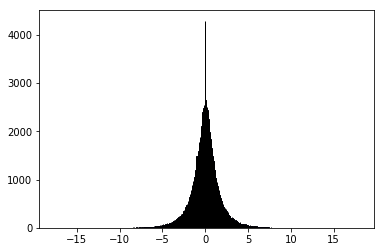

In [430]:
plt.hist(a, bins=1000,
             color = 'blue', edgecolor = 'black')


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

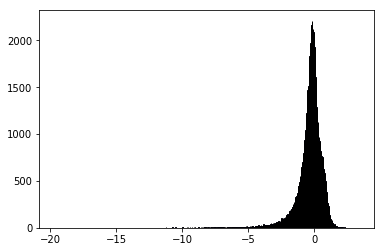

In [429]:
plt.hist(pred, bins=1000,
             color = 'blue', edgecolor = 'black')


In [432]:
train.shape

(201917, 6)

In [433]:
test.shape

(123623, 8)

In [434]:
len(train)/len(test)

1.633328749504542

In [435]:
1.633333*3

4.899998999999999

In [439]:
ytrain

(201917,)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
x = pd.read_csv('submission.csv')

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


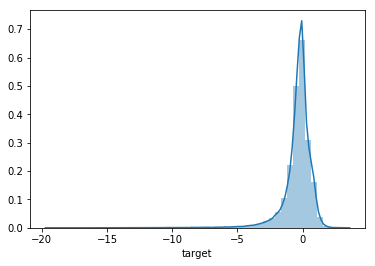

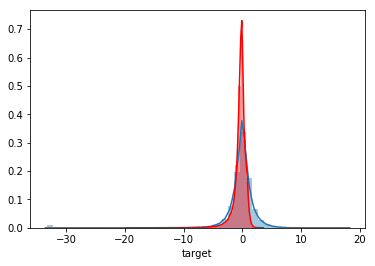

In [8]:
sns.distplot(train['target'])
sns.distplot(x['target'], color='r')

In [10]:
x[x['target']<-10]

,card_id,target
496,C_ID_a7d1cd6b7c,-10.955263
1732,C_ID_0d3a4db1a6,-10.819463
1772,C_ID_4299911620,-11.236495
2426,C_ID_c219067cd7,-11.123829
2726,C_ID_1edbae8171,-15.487766
4191,C_ID_87b47c2ac5,-10.392056
4960,C_ID_02e2f15572,-10.239856
5008,C_ID_be92f84f5c,-14.459133
5009,C_ID_695b445408,-10.937078
5656,C_ID_126a403be9,-14.591207


In [11]:
x['target'].max()

3.411530879362607